## This file is to train based on the formated dataset extracted from the image processing, and validation on the output. 

### CAADRIA 2020 Pre-Workshop
##### http://papers.cumincad.org/data/works/att/caadria2018_083.pdf



### Import Library

In [2]:
import cv2
import os
import numpy as np
from skimage import morphology,data,color
import matplotlib.pyplot as plt
from image_utils import *
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, Reshape, BatchNormalization, TimeDistributed, Lambda, \
    Activation, LSTM, Flatten, Convolution1D, GRU, MaxPooling1D, Bidirectional
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras import initializers
from keras import backend as K
from keras.optimizers import SGD
import math
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

### Import prepared dataset. 
Each bending strip recored the bottom coordinate, middle coordinate, tangent vector and thickness at each sample point.

In [3]:
raw_datas = np.load('all_datas.npy')
len(raw_datas),raw_datas.shape,raw_datas[1][1].shape

(1456, (1456, 4), (93, 2))

In [4]:
midSelect,bottomSelect,vectorSelect,thickness=zip(*raw_datas)
midSelect[0][:2],bottomSelect[0][:2],vectorSelect[0][:2]

(array([[231.00188, 427.     ],
        [225.33504, 426.     ]], dtype=float32), array([[231, 419],
        [226, 419]]), array([[-0.00564135,  0.9999841 ],
        [-0.08307201,  0.9965435 ]], dtype=float32))

### Reverse cordinality 
Because the original coordinates are inversed, to that we need to reverse them. If we take the lower bottom right point as the origin point, here we have:

In [5]:

ms=bottomSelect[0][0]-midSelect[0]
bs=bottomSelect[0][0]-bottomSelect[0]
ms=ms[:,[1,0]]
bs=bs[:,[1,0]]
vs=vectorSelect[0][:,[1,0]]*[-1,-1]
ms[:5],bs[:5],vs[:5]

(array([[-8.00000000e+00, -1.87683105e-03],
        [-7.00000000e+00,  5.66496277e+00],
        [-6.00000000e+00,  9.66369629e+00],
        [-5.00000000e+00,  1.40000000e+01],
        [-5.00000000e+00,  1.95028076e+01]]), array([[ 0,  0],
        [ 0,  5],
        [ 1,  9],
        [ 1, 14],
        [ 1, 19]]), array([[-9.99984086e-01,  5.64135052e-03],
        [-9.96543527e-01,  8.30720142e-02],
        [-9.96551692e-01,  8.29744563e-02],
        [-1.00000000e+00, -1.01731799e-04],
        [-9.96550024e-01,  8.29944238e-02]]))

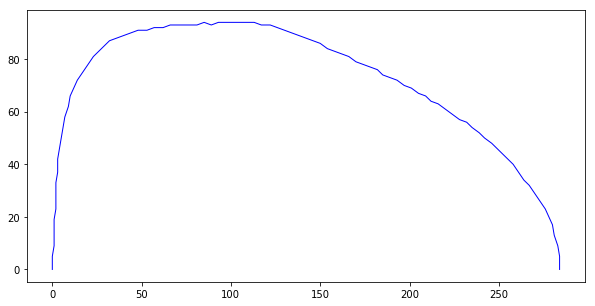

In [6]:
x,y=zip(*bs)
plt.figure(figsize=(10,5))
plt.plot(x,y,'b',linewidth=1)

In [7]:
len(thickness)

1456

### Data Analysis
check the distribution of thickness, (the 1px on the image equals approx. 0.195cn in reality)
If its off too much, it could be an anomaly 

135371 0.19546324002609697 4.382006367794496


(array([1.41159067e-04, 1.69390881e-03, 1.46452532e-02, 3.71601245e-02,
        2.59097468e-01, 3.16231601e-01, 5.20841669e-01, 2.55815520e-01,
        6.78516347e-01, 4.80858363e-01, 6.98666804e-01, 3.35993870e-01,
        6.00561252e-01, 2.98692587e-01, 2.29489354e-01, 3.86775845e-02,
        9.84584495e-03, 1.41159067e-04, 7.05795337e-05, 7.05795337e-05]),
 array([0.19546324, 0.4047904 , 0.61411755, 0.82344471, 1.03277187,
        1.24209902, 1.45142618, 1.66075333, 1.87008049, 2.07940765,
        2.2887348 , 2.49806196, 2.70738912, 2.91671627, 3.12604343,
        3.33537059, 3.54469774, 3.7540249 , 3.96335206, 4.17267921,
        4.38200637]),
 <a list of 20 Patch objects>)

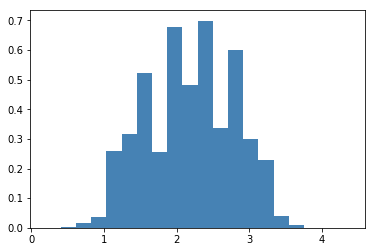

In [8]:

all_thickness=[_t*0.195*2 for t in thickness for _t in t if _t*0.195*2 < 5]
print(len(all_thickness),min(all_thickness),max(all_thickness))
plt.hist(all_thickness, bins=20, color='steelblue', density=True )

### Data Analysis
Check the overall length of all samples

1456 22 114


(array([0.00074654, 0.00044792, 0.00014931, 0.00014931, 0.00104515,
        0.00014931, 0.        , 0.00014931, 0.00089584, 0.00134376,
        0.00268753, 0.00447922, 0.01672241, 0.02239608, 0.01776756,
        0.03389274, 0.02209747, 0.02866699, 0.04927138, 0.01433349]),
 array([ 22. ,  26.6,  31.2,  35.8,  40.4,  45. ,  49.6,  54.2,  58.8,
         63.4,  68. ,  72.6,  77.2,  81.8,  86.4,  91. ,  95.6, 100.2,
        104.8, 109.4, 114. ]),
 <a list of 20 Patch objects>)

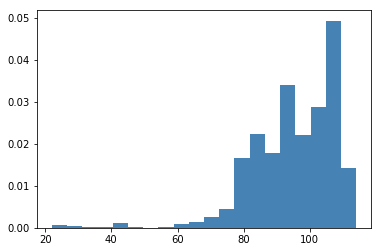

In [9]:
len_thickness=[len(t) for t in thickness]
print(len(len_thickness),min(len_thickness),max(len_thickness))
plt.hist(len_thickness, bins=20, color='steelblue', density=True )

### Check the number of qualified samples

In [10]:

print(len([t for t in thickness if max(t)*0.195*2 < 5 and len(t) > 80 ]))

1259


### Preparing Training dataset:
Take a countinious 80 points as a segment.

X1:[Gradient0, start width, end width]

Y2:[Start width, second width....End width]

PS. gradien is calculate as the arc value of the angle between the normal vector and the x axis. positive is counter clockwise and negatice is clockwise 

In [11]:

all_data=[]
test_data=[]
hw=40
#midSelect,bottomSelect,vectorSelect,thickness
for i in range(len(bottomSelect)):
    if max(thickness[i])*0.195*2 > 5:
        continue
    ms,bs,vs,tn = midSelect[i],bottomSelect[i],vectorSelect[i],thickness[i] 
    ms=bs[0]-ms
    bs=bs[0]-bs
    ms=ms[:,[1,0]]
    bs=bs[:,[1,0]]
    vs=vs[:,[1,0]]*[-1,-1]
    tn = tn*0.195*2/5*2-1 #归一化到[-1,1]
    
    gradiant=[math.acos(vx/(vx**2+vy**2)**0.5)*int(vy/abs(vy))/3.1416 if vy!=0 else 0 for vx,vy in vs]

    train_x=[]
    train_y=[]
    for j in range(hw,len(ms)-hw):
        train_x.append(gradiant[j-hw:j+hw]+[tn[j-hw]]+[tn[j+hw-1]])
        train_y.append(tn[j-hw:j+hw])
        
    #Leave a few for testing
    if i <= 10:
        vms,vbs=[],[]
        for j in range(hw,len(ms)-hw):
            vms.append(ms[j-hw:j+hw])
            vbs.append(bs[j-hw:j+hw])
        test_data.append([train_x,train_y,vms,vbs])
    else:
        all_data.append([train_x,train_y])

In [12]:
X,Y=zip(*all_data)
X=np.array([_x for x in X for _x in x])
Y=np.array([_y for y in Y for _y in y])
print(X.shape,Y.shape)
print(X[1])

(22723, 82) (22723, 80)
[-0.95491526 -0.96426022 -0.95419045 -0.93955225 -0.93714554 -0.93719301
 -0.93723149 -0.94746991 -0.93716021 -0.93714283 -0.93279528 -0.93040175
 -0.9304184  -0.93279572 -0.93713953 -0.95485499 -0.99990181  0.
  0.99999338  0.95517098  0.89763575  0.85211778  0.82799982  0.79517886
  0.7687908   0.75001107  0.7373014   0.73619108  0.73179045  0.72729698
  0.73487139  0.72116335  0.71050345  0.70014132  0.69436246  0.70018679
  0.69751941  0.68717253  0.64763445  0.63582477  0.61421571  0.57789318
  0.49970481  0.41486115  0.3830725   0.37257137  0.35240958  0.33480508
  0.32798495  0.32235481  0.31285304  0.30248301  0.29518415  0.29159333
  0.27898166  0.27885189  0.27161354  0.26513965  0.26383093  0.25004094
  0.25001456  0.23617928  0.23134705  0.22554974  0.21733061  0.21811845
  0.21041601  0.20482783  0.19743792  0.19274686  0.17563698  0.16310768
  0.1475792   0.13127419  0.12141503  0.10247842  0.0950071   0.08435581
  0.07798453  0.06283207  0.1030865

In [16]:
model = Sequential()
model.add(Dense(input_dim=len(X[0]), output_dim=512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_dim=512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_dim=512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_dim=256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_dim=len(Y[0]), activation="tanh"))

In [17]:
model.compile(loss="mse", optimizer="adam")

In [18]:
history = model.fit([X],
                     Y,
                     batch_size=16,
                     epochs=20,  
                     validation_split=0.3,
                     verbose=True,
                     shuffle=True,
                     )

Train on 15906 samples, validate on 6817 samples
Epoch 1/20
15906/15906 [==============================] - 7s 436us/step - loss: 0.0475 - val_loss: 0.0588
Epoch 2/20
15906/15906 [==============================] - 6s 394us/step - loss: 0.0406 - val_loss: 0.0565
Epoch 3/20
15906/15906 [==============================] - 6s 396us/step - loss: 0.0388 - val_loss: 0.0549
Epoch 4/20
15906/15906 [==============================] - 6s 397us/step - loss: 0.0370 - val_loss: 0.0537
Epoch 5/20
15906/15906 [==============================] - 6s 399us/step - loss: 0.0359 - val_loss: 0.0550
Epoch 6/20
15906/15906 [==============================] - 6s 399us/step - loss: 0.0348 - val_loss: 0.0522
Epoch 7/20
15906/15906 [==============================] - 6s 407us/step - loss: 0.0341 - val_loss: 0.0522
Epoch 8/20
15906/15906 [==============================] - 6s 406us/step - loss: 0.0332 - val_loss: 0.0530
Epoch 9/20
15906/15906 [==============================] - 6s 404us/step - loss: 0.0326 - val_loss: 0.05

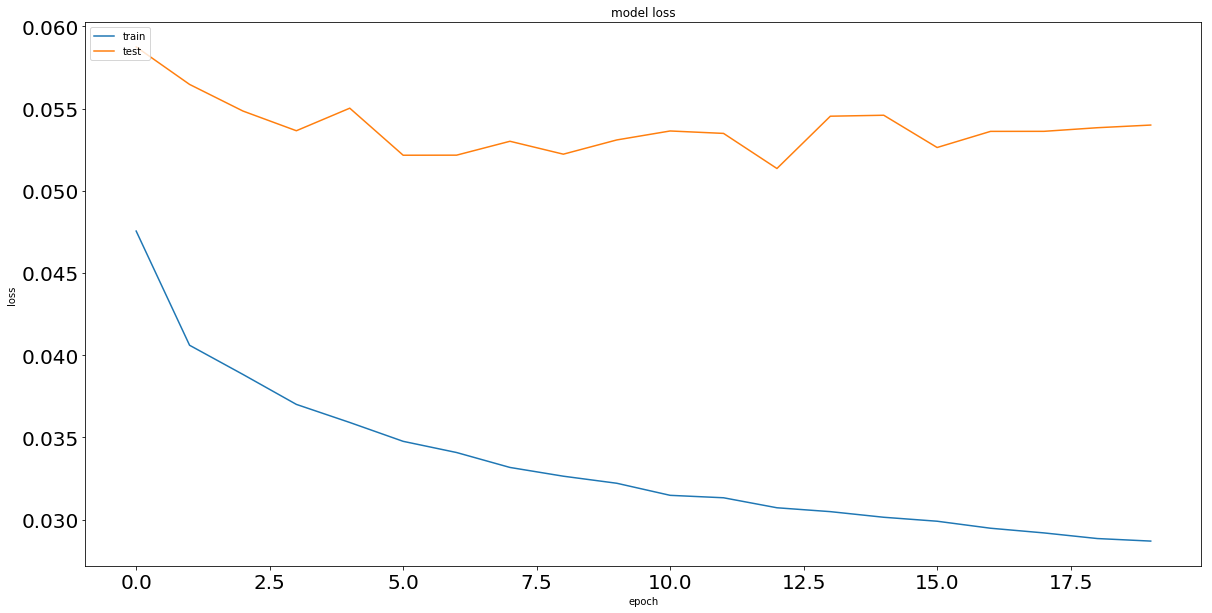

In [19]:
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Check the outcome of the fitting
Use the test dataset

In [96]:
print(len(test_data))
for i in range(len(test_data)):
    print(len(test_data[i][0]))

11
12
13
12
12
14
13
13
14
11
13
13


### Get a segment to test

In [102]:
test_x,test_y,test_ms,test_bs=list(zip(*test_data[3]))[8]

In [103]:
test_x,test_y,test_ms,test_bs = np.array([test_x]),np.array(test_y),np.array(test_ms),np.array(test_bs)
print(test_x.shape,test_y.shape,test_ms.shape,test_bs.shape)

(1, 82) (80,) (80, 2) (80, 2)


### When g==0, there will be problem with the +/- of vs, use the adjacent points to give reference.

In [105]:
def vx_sign(vx,i):
    start=max(i-5,0)
    tmp_vx=vx[start:start+10]
    if sum([_t/abs(_t) for _t in tmp_vx])>0:
        return 1
    else:return -1

In [106]:
ps = model.predict([test_x])
gradiant=np.squeeze(test_x)[:80]
ps = (np.squeeze(ps)+1)/2*5/2/0.195
ms_x,ms_y=zip(*test_ms)
bs_x,bs_y=zip(*test_bs)
vx=np.array([math.cos(abs(g)*3.1416) for g in gradiant])
for i in range(len(gradiant)):
    if gradiant[i]==0:
        vx[i] *= vx_sign(vx,i)
vy=(1-vx**2)**0.5*np.array([int(g/abs(g)) if g!=0 else 0 for g in gradiant])
ts_x=vx*ps+bs_x
ts_y=vy*ps+bs_y

### Visualize the outcome

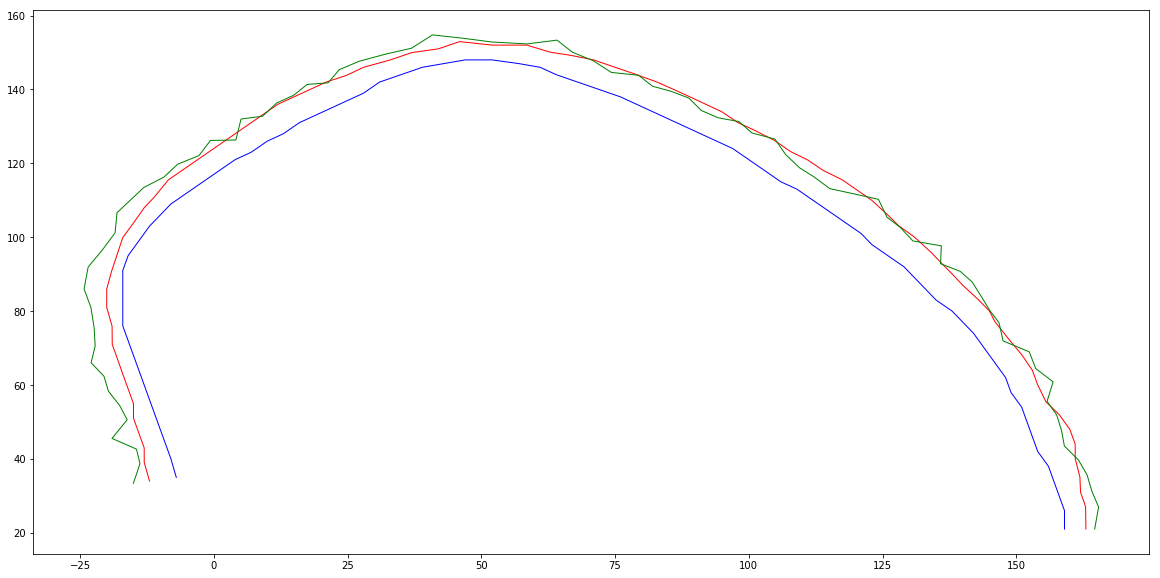

In [107]:
plt.figure(figsize=(20,10))
plt.plot(bs_x,bs_y,'b',linewidth=1)
plt.plot(ms_x,ms_y,'r',linewidth=1)
plt.plot(ts_x,ts_y,'g',linewidth=1)